In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# We uploaded our notebook and data (images, cached features, and captions) onto Google Colaboratory to make use of Google's computing power.
# There are a few things that must be done.
# First, we must unzip the folder containing our training and validation images (6m 32s).

In [ ]:
# !unzip '/content/drive/MyDrive/Image_Captioning/val.zip' -d '/content/drive/My Drive/Image_Captioning/data'

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image
from tqdm import tqdm
import pandas as pd
import glob

In [ ]:
%cd /content/drive/MyDrive/Image_Captioning

/content/drive/MyDrive/Image_Captioning


In [ ]:
# Listing the paths, subpaths, and filenames of interest.
annotations_path = {'val':'/val_cleaned.json'}
images_path = {'val':'/data/val/'}

# Generating 2-tuples, where the first entry houses the captions and the second entry houses the associated image paths.
# We shall do this again once we have processed the images according to the requirements of ResNet-50 and
# once we have tokenized and padded our captions.

# In order to shorten computing time, we only use the validation dataset, which has 6,982 images and 32,299 captions.
# We take 80% of those examples for the training phase, and the rest for the validation phase.
# Note that we did train on the entire dataset (21,220 images and 98,015 captions) for a single epoch.
# This took almost 4.5 hours to complete.

def captions_and_images (dataset):

# First, we open the data set, which is saved as a .json file.
    with open(os.path.abspath('.') + annotations_path[dataset], 'r') as f:
        data = json.load(f)

# Translating the .json file from the above to a Pandas data frame.
    df = pd.DataFrame.from_dict(data, orient='index')
    df = df.reset_index() # Before we can iterate over the index, indices of neighboring entries must differ by 1.
    # Neighboring indices do not always differ by 1 since we have removed images from our dataset.
    df = df.drop(['index'], axis = 1) # Resetting the index creates a column that houses the previous indices, so we drop it.

# We collect the image path and caption of every row.
# Then, we form a dictionary, whose keys are the image paths and whose values are the associated captions.
    image_path_to_caption = collections.defaultdict(list)
    for n in range(df.shape[0]):
        image_path = os.path.abspath('.') + images_path[dataset] + df.file_name.iloc[n]
        caption = f'<start> {df.caption.iloc[n]} <end>' # The curly brackets ensures that outputs are turned into text.
        image_path_to_caption[image_path].append(caption)

# We now separate the captions and image paths in 2 lists.
    captions = [] 
    img_name_vector = []

    for image_path in image_path_to_caption.keys(): # The keys are unique, so we only see each image path once.
        caption_list = image_path_to_caption[image_path] # Each image has at least 3 captions.
        captions.extend(caption_list) # We add the captions to the captions list.
        img_name_vector.extend([image_path]*len(caption_list)) # We add the image path multiple times to reflect that images have
        # multiple captions.
    return captions, img_name_vector

In [ ]:
# The function below will output a preprocessed image ready for ResNet-50 and its path.
def load_image (image_path):
    image = tf.io.read_file(image_path) # loads the raw data as a string
    image = tf.image.decode_jpeg(image, channels = 3) # decodes JPEG-encoded image to a uint8 (8-bit unsigned integer) tensor
    image = tf.image.resize(image, (224,224)) # resizes the tensor above to agree with the input size of ResNet-50
    image = tf.keras.applications.resnet50.preprocess_input(image) # Take cares of other ResNet-50 preprocessing steps, such as
    # going from a RGB to a BGR channel. Also, every channel is zero-centered relative to the ImageNet data set.
    # What does it mean to zero-center a color channel?
    return image, image_path

In [ ]:
# The output of load_image is:
# tf.Tensor of shape == (224, 224, 3), whose entries are float32 and the image path.
# The first index accesses the img_name_vector entry, the second index acceses the 0th file path, and
# the third index accesses the processed image.
# load_image(captions_and_images('train')[1][0])[0]
# load_image(captions_and_images('train')[1][0])[1]

In [ ]:
# Creating a model where the input layer will receive our images and the output layer is the last convolutional layer of ResNet50.
# After the images have run its course through the model, we store the output as a vector, which contains all the extracted features.
# We save these extracted features to disk.

def cache_extracted_features (dataset):

# We instantiate the ResNet-50 model without the top layer and load the ImageNet weights.
# Setting include_top to False results in dropping these 2 layers: avg_pool (GlobalAveragePooling2) and predictions (Dense).
    image_model = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet')

    new_input = image_model.input # We grab the input of the model.
    hidden_layer = image_model.layers[-1].output # We grab the last layer's output.

# We build a model using the functional API whose input and output are defined above.
    image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

# We extract only the unique paths and then sort them.
    encode_data = sorted(set(img_name_vector))

# We use the data API to generate a sequence of data items.
# Note that as of now the image_dataset is a sequence of tensors that contain strings reflecting our file paths.
    image_dataset = tf.data.Dataset.from_tensor_slices(encode_data)

# We can take a peak of the first element of this dataset by running the following code:
# for item in image_dataset.take(1):
#     print(item)
# The output for the training data set is:
# tf.Tensor(b'/Users/calvin/projects/mlp_1/data/images/train/VizWiz_train_00000000.jpg', shape=(), dtype=string)

# We use the map method to apply the load_image function to our dataset.

# tf.data.AUTOTUNE ensures that the number of batches that are computed in parallel is based on available sources.
# The batch method sets the number of images that are dealt with in a single batch.
    image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

# After applying the load_image function to our dataset, we obtain images that have been processed,
# i.e., they have been read, decoded, resized, and preprocessed according to the requirements of ResNet-50.

# As before, we can see the output of this newly transformed image_dataset with the following code:
# for item in image_dataset.take(1):
#    print(item)
# The output is a tf.Tensor of shape == (batch_size, 224, 224, 3) with (batch_size) image paths.

# Now that we have a sequence of data items, specifically, a preprocessed image and its associated file path we perform
# the following for loop.

# First, we extract the features of our image. Then, we resize the extracted features.
    for img, path in tqdm(image_dataset):
        batch_features = image_features_extract_model(img) 
        batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3])) 

# We perform another for loop, but this time it is not over the 2-tuple, (image, path) it is over the 2-tuple,
# (extracted features, paths). Lastly, we save the path to a binary file using the file format, (...).npy.
        for bf, p in zip(batch_features, path):
            path_of_feature = p.numpy().decode("utf-8")
            np.save(path_of_feature, bf.numpy())

In [ ]:
# We use list comprehension to generate the lengths of all the elements of the input, tensor.
# Then, we return the element with the longest length.
# Note that writing max([...]) is valid too, but one can get away with leaving out the square brackets.
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
# We tokenize and pad our captions.
def tokenize_pad (captions):
    
    top_k = 5000 # We set a limit to the number of words we hold in our vocabulary, namely only the (top_k - 1) frequent words.

# num_words: determines the maximum number of words to keep, i.e., only the (num_words - 1) most common words are kept.
# oov_token: if we encounter a word that is not part of our vocabulary, then we assign it the special token, <unk>.
# filters: a string of characters that are filtered from the text being analyzed.
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, oov_token="<unk>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')

# We update our internal vocabulary based on the captions we extracted from the data frame above.
# Note that we feed a list of captions to our model, not a sequence, so we use fit_on_texts, rather than fit_on_sequences.
    tokenizer.fit_on_texts(captions)

# Creating a word to index and index to word mappings.
# We reserve the index, 0 for the special token, <pad>.
    tokenizer.word_index['<pad>'] = 0
    tokenizer.index_word[0] = '<pad>'

# Transforming our collection of texts into a sequence of integers.
# As we mentioned above, only the (num_words - 1) most frequent word are taken into account.
    seqs = tokenizer.texts_to_sequences(captions)
    max_length = calc_max_length(seqs)

# Note that we can check the inner workings of our tokenizer with the following methods and attributes of Tokenizer:
# get_config(), index_word, word_index.

# Note that we did not lower the characters of our string because this is taken care by the default settings of
# tf.keras.preprocessing.text.Tokenizer.

# One can access the index to word mapping and recover the 0th caption by first accessing the indices of the 0th entry
# of seqs and passing that sequence of integers into the index to word mapping. This can be replicated for padded captions, too.

# Not all sequences share the same length, so we first find the longest sequence, and then we add 0's to all sequences shorter than
# the longest sequence.
    cap_vector = tf.keras.preprocessing.sequence.pad_sequences(seqs, padding='post') 

    return cap_vector, tokenizer, seqs

In [ ]:
# We make sure that we can retrieve a functioning tokenizer from above because we will be accessing the tokenizer
# during the training phase.
# tokenizer_val= tokenize_pad(captions_and_images('val')[0])
# We print the first 8 indices and their associated words.
# for n in range(8):
#     print(n, tokenizer_val[1].index_word[n])

In [ ]:
# Confirming that our choice of num_words is fulfilled.
# largest = 0
# for n in range(len(tokenizer_val[0])):
#     temp = np.max(tokenizer_val[0][n])
#     if temp > largest:
#         largest = temp
# print(largest)

In [ ]:
# captions_test = captions_and_images('val')[0][0]
# print(captions_test) # generating the 0th caption
# print([tokenizer_val[1].index_word[n] for n in tokenizer_val[2][0]]) # generating the 0th caption (tokenized)
# tokenized_padded_test = [tokenizer_val[1].index_word[n] for n in tokenizer_val[0][0]]
# print(tokenized_padded_test) # generating the 0th caption (tokenized and padded)
# print(len(tokenized_padded_test)) # generating the maximum length of the tokenized/padded captions from the validation set

In [ ]:
# The maximum lengths of our tokenized/padded captions for the training set is 115.
# The maximum lengths of our tokenized/padded captions for the validation set is 157.
# The second zero accesses cap_vector, which is array where each row is a caption,
# so the third zero accesses the 0th tokenized/padded caption.
# print(len(tokenize_pad(captions_and_images('train')[0])[0][0]))
# print(len(tokenize_pad(captions_and_images('val')[0])[0][0]))

In [ ]:
# Just as did before with captions_and_images, we generate 2-tuples, where
# the first entry are the image paths to the preprocessed images and
# the second entry are the associated tokenized and padded captions.

def pro_img_and_tok_cap (dataset):

# Just as before with captions_and_images, the pattern we follow is:
# Generate a dictionary, where the keys are the images and the values are all of its associated captions (at least 3).
# Generate 2 lists, where the first holds the captions and the second holds the images (multiplicity taken into account).
    img_to_cap_vector = collections.defaultdict(list) # keys are image paths, values are tokenized/padded captions.
    
# Recall that the output of captions_and_image(dataset) is (captions, img_name_vector).
# Recall that the output of tokenize_pad(captions) is cap_vector, tokenizer, seqs.

# img_name_vector is captions_and_images(dataset)[1].
# First, define captions_and_images_data = captions_and_images('data') ('train' or 'val').
# Second, captions_and_images_data[1] gives the img_name_vector for the dataset, data.

# cap_vector is tokenize_pad(captions)[0].
# First, define tokenize_pad_data = tokenize_pad(captions_and_images_data[0]).
# Note that tokenize_pad_data[0] is cap_vector for the dataset, data.

    captions_and_images_data = captions_and_images(dataset)
    img_name_vector = captions_and_images_data[1]
    cap_vector = tokenize_pad(captions_and_images_data[0])[0]

    for img, cap in zip(img_name_vector, cap_vector):
        img_to_cap_vector[img].append(cap)

    # We now create the training and validation split.
    img_keys = list(img_to_cap_vector.keys()) # first we generate the unique keys, i.e., the unique image paths.
    random.shuffle(img_keys) # shuffling all the keys
    slice_index = int(len(img_keys)*0.8) # we create an indexing scheme that separates the first 80 percent of the recently shuffled dataset
    
    img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]
    
    # We now create 2 lists per dataset (training and validation), which house the images and captions.

    img_name_train = []
    cap_train = []

    for imgt in img_name_train_keys:
        capt_len = len(img_to_cap_vector[imgt])
        img_name_train.extend([imgt] * capt_len)
        cap_train.extend(img_to_cap_vector[imgt])

    img_name_val = []
    cap_val = []

    for imgv in img_name_val_keys:
        capv_len = len(img_to_cap_vector[imgv])
        img_name_val.extend([imgv] * capv_len)
        cap_val.extend(img_to_cap_vector[imgv])
    
    return img_name_train, cap_train, img_name_val, cap_val

In [ ]:
# We list parameters which will be used later on.

# BATCH_SIZE = 64
# BUFFER_SIZE = 1000 or buffer_size=tf.data.AUTOTUNE

# embedding_dim = 256 (used in the CNN encoder and RNN decoder models)
# units = 512 (used in the RNN decoder and Bahdanau attention models)
# vocab_size = top_k + 1 (used in the RNN decoder model)

# num_steps equals the number of captions in our dataset divided (integer or floor) by the batch size.
# The number of captions is 98,015 and 32,299 for the training and validation dataset, respectively.
# These values can be found when we preprocess the data in 3_preprocessing_train_val.ipynb.

# num_steps = len(pro_img_and_tok_cap(dataset)[0]) // BATCH_SIZE

# Shape of the vector extracted from InceptionV3 is (64, 2048).
# Shape of the vector extracted from ResNet50 is (49, 2048).

# features_shape = 2048
# attention_features_shape = 49

In [ ]:
# The function below is used to load the numpy files, which house the extracted features.
# Note that the output is the extracted features of the processed image and its associated caption.
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
# We now create a tf.data.Dataset dataset which will be fed into our models.
# We added an option to control the batch_size in order to easily generate the dimensionality of the variables.
def create_dataset (data):
    # Creating a sequence of data items.
    _pro_img_and_tok_cap = pro_img_and_tok_cap(data)
    dataset = tf.data.Dataset.from_tensor_slices((_pro_img_and_tok_cap[0], _pro_img_and_tok_cap[1])) # single positional argument!

    # Use map to load the numpy files holding the cached features in parallel.
    # We use tf.numpy_function to promote the Python function to a TensorFlow operation.
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
            map_func, [item1, item2], [tf.float32, tf.int32]),
            num_parallel_calls=tf.data.AUTOTUNE)

    # Shuffling and creating batches
    dataset = dataset.shuffle(1000).batch(64) 
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset, _pro_img_and_tok_cap

In [ ]:
# Run this block in order to take a look at the shape of the outputs of create_dataset.
# We do this for the validation dataset and set the batch size to 2 in order to shorten the computation time.
# dataset_val_test = create_dataset('val', 2)
# for item in dataset_val_test.take(1):
#     print(item)
# The outputs are as follows:
# The first entry is the processed image: tf.Tensor of shape == (batch_size = 2, 49, 2048), float32
# The second entry is the tokenized/padded caption: tf.Tensor of shape == (batch_size = 2 , 157), int32

In [ ]:
# We also investigate the shape of several variables that will play a crucial role in what follows.
# count = 0
# for (batch, (img_tensor, target)) in enumerate(dataset_val_test):
#     if count == 1:
#         break
#     print(batch)
#     print(f'This is the shape of img_tensor, {img_tensor.shape}')
#     print(f'This is the shape of target, {target.shape}')
#     x = tf.expand_dims([tokenizer_val[1].word_index['<start>']] * target.shape[0], 1) # initial decoder input
#     print(f'This is the shape of x, {x.shape}')
#     # print(x)
#     y = target[1,:]
#     print(f'This is the shape of y, {y.shape}')
#     # print(y)
#     # print([tokenizer_val[1].index_word[n] for n in y.numpy()])
#     z = tf.expand_dims(target[:,2],1) # decoder input a la teaching forcing
#     print(f'This is the shape of z, {z.shape}')
#     # print(z)
#     count += 1

In [ ]:
# We are now ready to tackle our encoder-decoder model.
# First, we built the CNN encoder.

class CNN_Encoder(tf.keras.Model):

    # We are subclassing tf.keras.Model so we define our layers in __init__ and any operations this model
    # will carry out in the call function, which can be executed by entering: CNN_Encoder(embedding_dim)(x).

    # The syntax has changed in Python 3.0, so we can replace super(CNN_Encoder, self).__init__() with super().__init__()
    
    def __init__(self, embedding_dim):
        super().__init__()
        # x before fc: (batch_size, 49, 2048)
        # x after fc == (batch_size, 49, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x, print_stuff):
        if print_stuff:
            print(f'Shape of img_tensor before dense layer and ReLU (CNN): {x.shape}.')
        x = self.fc(x)
        x = tf.nn.relu(x)
        if print_stuff:
            print(f'Shape of img_tensor after dense layer and ReLU (CNN): {x.shape}.')
        return x

In [ ]:
# Execute the block below to see the output shape of the encoder.
# for (batch, (img_tensor, target)) in enumerate(dataset_val_test):
#     x = CNN_Encoder(256)(img_tensor, True)
#     break

In [ ]:
# Building the attention model.

class BahdanauAttention(tf.keras.Model):

  def __init__(self, units):
    super().__init__()
    # We are implementing Bahdanau attention so we will need 2 layers, so that the hidden state and the encoder output each
    # get assigned and multiplied by their own weights.
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    
    # The last layer has a single neuron because we wish to generate weights that are numbers, not tensors.
    self.V = tf.keras.layers.Dense(1)
    
  def call(self, features, hidden, print_stuff):
    # features: (batch_size, 49, embedding_dim)
    # hidden: (batch_size, hidden_size = units) these units are inherits from GRU
    # hidden_with_time_axis: (batch_size, 1, hidden_size = units) time is a scalar, so a single number will suffice
    hidden_with_time_axis = tf.expand_dims(hidden, 1)
    if print_stuff:
      print(f'Shape of hidden_with_time_axis (Bahdanau): {hidden_with_time_axis.shape}.')

    W1_product = self.W1(features)
    if print_stuff:
      print(f'Shape of W1_product: {W1_product.shape}.')

    W2_product = self.W2(hidden_with_time_axis)
    if print_stuff:
      print(f'Shape of W2_product: {W2_product.shape}.')

    # attention_hidden_layer: (batch_size, 49, hidden_size = units)
    # tf.nn.tanh has been replaced by tf.math.tanh
    attention_hidden_layer = (tf.math.tanh(W1_product + W2_product))
    if print_stuff:
      print(f'Shape of attention_hidden_layer (Bahdanau): {attention_hidden_layer.shape}.')

    # score: (batch_size, 49, 1)
    score = self.V(attention_hidden_layer)
    if print_stuff:
      print(f'Shape of score (Bahdanau): {score.shape}.')

    # attention_weights: (batch_size, 49, 1)
    attention_weights = tf.nn.softmax(score, axis=1)
    if print_stuff:
      print(f'Shape of attention_weights (Bahdanau): {attention_weights.shape}.')

    # context_vector before sum: (batch_size, 49, embedding_dim)
    # context_vector after sum: (batch_size, hidden_size = units)
    if print_stuff:
      print(f'Shape of features: {features.shape}.')
    context_vector = attention_weights * features # element-wise multiplication with broadcasting
    if print_stuff:
      print(f'Shape of context vector before sum (Bahdanau): {context_vector.shape}.')
    context_vector = tf.reduce_sum(context_vector, axis=1)
    if print_stuff:
      print(f'Shape of context vector after sum (Bahdanau): {context_vector.shape}.')

    return context_vector, attention_weights

In [ ]:
# We now built the decoder model.
class RNN_Decoder(tf.keras.Model):

  def __init__(self, embedding_dim, units, vocab_size):
    super().__init__()
    self.units = units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)
    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden, print_stuff):

    # The Bahdanau attention model takes in 2 inputs, features and hidden:

    # features: the output of the encoder (ResNet-50) acting on our images
    # features shape == (batch_size, 49, embedding_dim)

    # hidden: the hidden state of our GRU
    # hidden shape == (batch_size, hidden_size = units), where
    # hidden_size is determined by the number of neurons our GRU has.

    # Bahdanu outputs a weighted sum of the encoder outputs (context_vector) and the weights (attention_weights) used in that sum
    context_vector, attention_weights = self.attention(features, hidden, print_stuff)

    # x is the decoder input, which takes on the form: dec_inc = tf.expand_dims(target[:,i],1)
    # x (dec_input): (batch_size, 1)

    # Using the tokenizer, one maps the integers featured in the target to a caption, specifically,
    # we generate the ith tokenized word of (batch_size) captions partcipating in some batch.

    # embedding: changes an n-index object to an (n+1)-index object, where the last index ranges over the output dim
    # x before embedding: (batch_size, 1)
    # x after embedding: (batch_size, 1, embedding_dim)
    x = self.embedding(x)
    if print_stuff:
      print(f'Shape of decoder input after embedding layer (RNN): {x.shape}.')

    # A GRU is fed 2 inputs, the input vector, x_t and the previous hidden state, h_{t-1} of the GRU and outputs,
    # an output vector, y_t (output) and the current hidden state, h_t (state) of the GRU.

    # We feed the embedded decoder input concatenated with the context vector from our attention model into the GRU.

    # context vector before expansion: (batch_size, hidden_size)
    # context vector after expansion: (batch_size, 1, hidden_size)
    # x: (batch_size, 1, embedding_dim)
    # x concatenated with context vector: (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    if print_stuff:
      print(f'Shape of concatenated expanded context vector with embedded decoder input (RNN): {x.shape}.')

    # passing the concatenated vector above to the GRU generates 2 outputs: output and state
    # shape of x before GRU: (batch_size, 1, embedding_dim + hidden_size)
    # shape of output: (batch_size, max_length, ?)
    # shape of state: (batch_size hidden_size = units)
    output, state = self.gru(x)
    if print_stuff:
      print(f'Shape of output of GRU (RNN): {output.shape}.')
      print(f'Shape of state of GRU (RNN): {state.shape}.')

    # output before fc1: (batch_size, max_length, ?)
    # output after fc1: (batch_size, max_length, hidden_size = units)
    x = self.fc1(output)
    if print_stuff:
      print(f'Shape of output of GRU after fc1 (RNN): {x.shape}.')

    # x before reshape: (batch_size, max_length, hidden_size = units)
    # x after reshape: (batch_size * max_length, hidden_size = units)
    # we force there to be (units) columns, and let TensorFlow take care of finding out the
    # number of rows needed in order to preserve the area of our tensor by inputting -1.
    x = tf.reshape(x, (-1, x.shape[2]))
    if print_stuff:
      print(f'Shape after reshaping (RNN): {x.shape}.')

    # x before fc2: (batch_size * max_length, hidden_size = units)
    # x after fc2: (batch_size * max_length, vocab_size)
    x = self.fc2(x)
    if print_stuff:
      print(f'Shape after fc2 (RNN): {x.shape}.')

    # x: model's prediction
    # hidden: model's hidden state
    # attention_weights: weights from attention
    if print_stuff:
      print(f'Shape of prediction (RNN): {x.shape}')
      print(f'Shape of hidden state (RNN): {state.shape}')
      print(f'Shape of attention weights (RNN): {attention_weights.shape}')
    return x, state, attention_weights

  # This function below unveils to us that the value of hidden_size is equal to units
  
  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
# We examine the print statements which shed light on the dimensionality of the various components of our model.
# embedding_dim = 256
# units = 512
# top_k = 5000
# vocab_size = top_k + 1

# encoder = CNN_Encoder(embedding_dim)
# decoder = RNN_Decoder(embedding_dim, units, vocab_size)

# for (batch, (img_tensor, target)) in enumerate(dataset_val_test):

#     dec_input = tf.expand_dims([tokenizer_val[1].word_index['<start>']] * target.shape[0], 1)

#     features = encoder(img_tensor, True)
#     print(f'Shape of features (CNN): {features.shape}.')

#     hidden = decoder.reset_state(batch_size=target.shape[0])
#     print(f'Shape of hidden generated from reset_state method (RNN): {hidden.shape}.')
    
#     decoder(dec_input, features, hidden, True)
#     break

In [ ]:
# Creating an instance of the encoder and decoder models.

embedding_dim = 256
units = 512
top_k = 5000
vocab_size = top_k + 1

encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:
optimizer = tf.keras.optimizers.Adam() # choosing a variant of stochastic gradient descent

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
    # This is ultimately a classification problem, where we wish to predict with high probability the next sensible word in our
    # caption, and a low probability for all other words. We have not one-hot encoded our words, so we do not use categorical
    # cross entropy. We have used integer labels instead, so we use sparse categorical cross entropy.

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0)) # a mask that reflects if real is not equal to 0
  loss_ = loss_object(real, pred) # calculating the loss relative to real and pred

  mask = tf.cast(mask, dtype=loss_.dtype) # promoting mask to a tensor with the dtype of loss_
  loss_ *= mask # The mask is full of 1's and 0's and the categorical cross entropy is a product of 1's and 0's with
  # the logarithm of a softmax probability.

  return tf.reduce_mean(loss_) # computing the mean across all dimensions

In [ ]:
# Setting up checkpoints.
checkpoint_path = "./checkpoints/train"
# Keeping track of trackable variables, such as the encoder, decoder, optimizer.
ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer=optimizer) 
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5) # We only allow the checkpoint manager
# to keep 5 checkpoints at most.

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [ ]:
loss_plot = []

In [ ]:
# We use the tokenizer for the training dataset at every training step, so we run it now.
# We also create the training dataset as we will use multiple times during training
# tokenizer_train = tokenize_pad(captions_and_images('train')[0])[1]
# dataset_train = create_dataset('train', 64)
# print(len(pro_img_and_tok_cap('train')[0]))

tokenizer_train = tokenize_pad(captions_and_images('val')[0]) # referred to as tokenizer_train, but originates from
# the validation dataset.
dataset_train = create_dataset('val') # referred to as dataset_train, but originates from the validation dataset

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0
  # initializing the hidden state for each batch because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  # The decoder input are the tokenized and padded captions. We initiate (batch_size) inputs to the start token
  # and an extra dimension to take into which step or time frame we are at.
  dec_input = tf.expand_dims([tokenizer_train[1].word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape: # used to keep track of certain variables, so we can efficiently carry out
    # backpropagation
      features = encoder(img_tensor, False) # The extracted features output of ResNet-50.

      for i in range(1, target.shape[1]):
          # target.shape[1] are the number maximum number of words any tokenized and padded caption can have.
          # We now pass the decoder input
          predictions, hidden, _ = decoder(dec_input, features, hidden, False)

          # The loss is given by comparing the ith word in our caption (entire batch selected with colon) and our predictions
          loss += loss_function(target[:, i], predictions)

          # Using teacher forcing means that the next decoder input is given by the word our model should have predicted.
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))
  
  # Here, we can appreciate why we wanted to inherit attributes and methods from tf.keras.Model.
  # tf.keras.Model inherits from tf.Module and tf.Module has an attribute called trainable_variables, which
  # is a collection of all the variables that are being trained.
  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables) # differentiate loss function with respect to all trainable variables

  optimizer.apply_gradients(zip(gradients, trainable_variables)) #

  return loss, total_loss

In [ ]:
EPOCHS = 13
num_steps = len(pro_img_and_tok_cap('val')[0]) // 64
    
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset_train[0]): # we create the dataset beforehand to avoid generating it
        # multiple times
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 2 ==0:
        ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 0.6849
Epoch 1 Batch 100 Loss 0.4287
Epoch 1 Batch 200 Loss 0.4095
Epoch 1 Batch 300 Loss 0.3654
Epoch 1 Batch 400 Loss 0.3291
Epoch 1 Loss 0.397367
Time taken for 1 epoch 3465.82 sec

Epoch 2 Batch 0 Loss 0.3618
Epoch 2 Batch 100 Loss 0.3123
Epoch 2 Batch 200 Loss 0.3281
Epoch 2 Batch 300 Loss 0.2853
Epoch 2 Batch 400 Loss 0.3182
Epoch 2 Loss 0.319472
Time taken for 1 epoch 211.57 sec

Epoch 3 Batch 0 Loss 0.3130
Epoch 3 Batch 100 Loss 0.2665
Epoch 3 Batch 200 Loss 0.2852
Epoch 3 Batch 300 Loss 0.2901
Epoch 3 Batch 400 Loss 0.2567
Epoch 3 Loss 0.287991
Time taken for 1 epoch 214.13 sec

Epoch 4 Batch 0 Loss 0.3024
Epoch 4 Batch 100 Loss 0.2562
Epoch 4 Batch 200 Loss 0.2545
Epoch 4 Batch 300 Loss 0.2615
Epoch 4 Batch 400 Loss 0.2544
Epoch 4 Loss 0.265846
Time taken for 1 epoch 212.59 sec

Epoch 5 Batch 0 Loss 0.2935
Epoch 5 Batch 100 Loss 0.2256
Epoch 5 Batch 200 Loss 0.2371
Epoch 5 Batch 300 Loss 0.2309
Epoch 5 Batch 400 Loss 0.2370
Epoch 5 Loss 0.248398
Time take

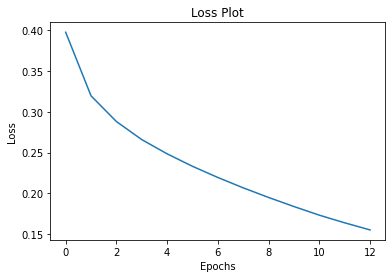

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
image_model = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet')
new_input = image_model.input 
hidden_layer = image_model.layers[-1].output 
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
def evaluate(image):
    max_length = 157
    attention_features_shape = 49
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val, False)

    dec_input = tf.expand_dims([tokenizer_train[1].word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden, False)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer_train[1].index_word[predicted_id])

        if tokenizer_train[1].index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [ ]:
rid = np.random.randint(0, len(dataset_train[1][2]))
image = dataset_train[1][2][rid]
real_caption = ' '.join([tokenizer_train[1].index_word[i]
                        for i in dataset_train[1][3][rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)